# **Classificação de fala usando Trasnformada de Fourier** 🤯
---


## **Alunos**:
* Marcus Vinicius de Faria Santos (mvfs)
* Mateus Ferreira Borges Soares   (mfbs2)
* Rodrigo Santos Batista          (rsb6)




CIn ­ UFPE

## **Algoritmos e técnicas usadas:**:

Modelo de detecção de fala
* Base de dados mini speech commands
* MFCCs
* CNN ( relu )
* Transformada de Fourier

## **Professor**:

Divanilson Rodrigo de Sousa Campelo

CIn ­ UFPE


# **Reconhecimento de comandos de voz**

---




image-2.png

# **Base de dados: Mini Speech Commands**

O conjunto de dados original consiste em mais de 105.000 arquivos de áudio no formato de arquivo de áudio WAV (Waveform) de pessoas dizendo 35 palavras diferentes. Mais detalhes sobre a base de dados podem ser vistos nestes link: [speech_commands](https://www.tensorflow.org/datasets/catalog/speech_commands)

Para economizar tempo com o carregamento de dados, será usada uma versão menor do conjunto de dados de Comandos de Fala chamada **mini_speech_commands** que contém clipes de áudio curtos (um segundo ou menos) de 8 comandos: "down", "go", "left", "no", "right", "stop", "up" e "yes".

* **A taxa de amostragem para este conjunto de dados é de 16kHz.**









# **MODELANDO**

In [1]:
import glob
import os
import pathlib
import random
from datetime import datetime
import librosa
import librosa.display as ld
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns
sns.set()
from tqdm import tqdm
import serial
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff


## **Funções usadas no código**

In [2]:
################################################################################## EDA ##################################################################################

# intera sobre o diretorio para definir as classes de audio
def path_commands(path):
  commands = []
  for name in glob.glob(str(path) + '/*' + os.path.sep):
    commands.append(name.split('\\')[-2])

  # transformando a lista para dict para que tenham uma chave associada a cada comando
  commands_dict = {i: commands.index(i) for i in commands}
  return commands, commands_dict


# Criando o dataset:
def dataset_create(path, commands_dict):
  speech_data_list   = []    # armazena o path dos arquivos
  speech_data_labels = []    # armazena os rótulos dos arquivos
  speech_data_int    = []    # armazena as variaveis numericas dos rótulos

  print("Diretório dos arquivos de audio:\n")
  for name in tqdm(glob.glob(str(path) + '\*\*')):
    speech_data_list.append(name)
  
  speech_data_list = [path.replace('/', '\\') for path in speech_data_list]
  
  print('\n\n')
  # embaralhar os arquivos para nao enviesar a rede neural
  random.seed(42)
  random.shuffle(speech_data_list)

  print("Classes dos arquivos de audio:\n")
  for audio in tqdm(speech_data_list):
    # busca o diretorio completo do audio
    speech_data_labels.append(os.path.dirname(audio).split('\\')[-1])

  print('\n\n')
  print("Classes dos arquivos de audio numericas:\n")
  for audio in tqdm(speech_data_labels):
    speech_data_int.append(commands_dict[audio])

  print('\n\n')
  print(f" Quantidade de audios no dataset: {len(speech_data_labels)} arquivos de audio")

  return speech_data_list, speech_data_labels, speech_data_int

# Carrega as amostras de audio do dataset
def load_audio(speech_data_list, sampling_rate=16000):
  loaded_speech_data = [] # Armazena as amostras extraidas do audio

  for audio in tqdm(speech_data_list):
    loaded_speech_data.append(librosa.load(audio, sr=sampling_rate))
  return loaded_speech_data

# cria o DataFrame
def create_dataframe(speech_data_labels, loaded_speech_data, speech_data_list):
  '''
  ARGS:
    speech_data_labels: labels dos arquivos de audio (ex: 'yes', 'no' ...)
    loaded_speech_data: as amostras extraídas de audio
    speech_data_list:  os caminhos para os arquivos de audio
  '''

  dataFrame = pd.DataFrame([speech_data_labels, loaded_speech_data, speech_data_list]).T
  dataFrame.columns = ['command', 'waves', 'path']
  return dataFrame


# cria uma lista com a duraçao de cada audio
def duration_of_recordings(commands, path, sample_rate=16000):
  recordings = [] # armazena a duração de cada arquivo de audio
  for label in commands:
    #print(label)
    waves = [f for f in os.listdir( path + '\\' + label) if f.endswith('.wav')]
    #print(waves)
    for wav in waves:
      data, sple_rate = librosa.load( path + '\\' + label + '\\' + wav, sr = sample_rate)
      recordings.append(float(len(data) // sple_rate))
  return recordings


################################ VISUALIZAÇAO ############################################

# plota a distribuiçao de classes
def plot_balanced_class(dataFrame):
  # Cria um DataFrame com a contagem de cada categoria
  count_dataFrame = pd.DataFrame(dataFrame['command'].value_counts()).reset_index()
  count_dataFrame.columns = ['command', 'count']

  # Cria o gráfico de barras com o Plotly Express
  fig = px.bar(count_dataFrame, x='command', y='count', title='<b>Balanceamento das Classes', color='command')
  # Ajuste as propriedades de layout para centralizar o título
  fig.update_layout(title_x=0.5)

  fig.show()


# plota forma de onda de um audio
def plot_audio_wav(dataFrame):
  n_files = dataFrame.shape[0]
  rnd = np.random.randint(0, n_files)
  fname = dataFrame.path[rnd]
  data, sample_rate = librosa.load(fname, sr=16000)
  Audio(data=data, rate=sample_rate)
  info = dataFrame.iloc[rnd].values
  title_txt = f'<b>Comando: {info[0]}'

  # Use plotly para plotar os dados
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=np.arange(len(data)) // sample_rate, y=data, mode='lines'))
  fig.update_layout(title=title_txt.upper(), xaxis_title='<b>Tempo (s)', yaxis_title='<b>Amplitude', title_x=0.5)
  fig.show()
  print('\n\n')
  # Reproduz o áudio carregado usando a função Audio do IPython.display
  audio = Audio(data=data, rate=sample_rate)

  bar = '|'
  print('*'*100)
  print(f'{bar}  Canais: ', len(data.shape))
  print('*'*100)
  print(f'{bar}  Número total de amostras:', data.shape[0])
  print('*'*100)
  print(f'{bar}  Arquivo:', fname)
  print('*'*100)
  print(f'{bar}  Taxa de amostragem:', sample_rate)
  print('*'*100)
  print(f'{bar}  Duração: ', len(data) / sample_rate)
  print('*'*100)
  print('\n\n')

  return audio

# plota gride de ondas de audio
def plot_grid_audio_waves(dataFrame, figsize=(15, 15)):
  random_samples = dataFrame.groupby('command').sample(1)
  audio_samples, labels = random_samples['path'].tolist(), random_samples['command'].tolist()

  rows = 4
  cols = 2
  fig, axs = plt.subplots(rows, cols, figsize=figsize)
  index = 0

  for col in range(cols):
      for row in range(rows):
          data, sample_rate = librosa.load(audio_samples[index], sr=None)
          time = np.arange(0, len(data)) / sample_rate
          axs[row][col].plot(time, data)
          axs[row][col].set_title('{}'.format(labels[index]))
          index += 1

  fig.tight_layout()
  plt.show()

# plota froma de onda no domineo da frequencia em 3D
def plot_audio_frequency3D(dataFrame):
  random_samples = dataFrame.groupby('command').sample(1)
  audio_samples, labels = random_samples['path'].tolist(), random_samples['command'].tolist()

  rows = 4
  cols = 2
  fig = go.Figure()

  for index, audio_sample in enumerate(audio_samples):
      data, sample_rate = librosa.load(audio_sample, sr=None)
      stft = librosa.stft(y=data)
      stft_db = librosa.amplitude_to_db(np.abs(stft))
      frequencies = librosa.fft_frequencies(sr=sample_rate)
      times = librosa.times_like(stft_db)

      fig.add_trace(go.Surface(
          z=stft_db,
          x=times,
          y=frequencies,
          colorscale='Spectral',
          name=labels[index]
      ))

  fig.update_layout(
      title='<b>Espectrogramas de Amostras de Áudio Aleatórias',
      scene=dict(
          xaxis_title='Tempo (s)',
          yaxis_title='Frequência (Hz)',
          zaxis_title='Amplitude (dB)'
      ),
      width=1300,
      height=900,
      scene_aspectmode='manual',  # Define o modo de proporção da cena como manual
      # scene_aspectratio=dict(x=3, y=2, z=2),  # Define a proporção da cena
      coloraxis=dict(colorbar=dict(orientation='h', x=0.1, y=0.05, len=2))  # Define a orientação e a posição da barra lateral
  )

  fig.show()

# plota forma de onda no domíneo da frequencia em 2D
def plot_fft_audio_frequency2D(dataFrame, figsize=(20,20)):
  random_samples = dataFrame.groupby('command').sample(1)
  audio_samples, labels = random_samples['path'].tolist(), random_samples['command'].tolist()

  rows = 4
  cols = 2

  fig, axs = plt.subplots(rows, cols, figsize=figsize)
  index = 0
  for col in range(cols):
      for row in range(rows):
          data, sample_rate = librosa.load(audio_samples[index], sr = None)
          stft = librosa.stft(y = data)
          stft_db = librosa.amplitude_to_db(np.abs(stft))
          img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
          axs[row][col].set_title('{}'.format(labels[index]))
          fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
          index += 1
  fig.tight_layout()

# plota forma de onda mfcc em 2D
def plot_mfcc_spectogram(dataFrame, figsize=(20,20)):
  # Supondo que 'rows', 'cols', 'audio_samples' e 'labels' já estejam definidos
  random_samples = dataFrame.groupby('command').sample(1)
  audio_samples, labels = random_samples['path'].tolist(), random_samples['command'].tolist()
  rows = 4
  cols = 2
  fig, axs = plt.subplots(rows, cols, figsize=figsize)
  index = 0
  for col in range(cols):
      for row in range(rows):
          data, sample_rate = librosa.load(audio_samples[index], sr = None)
          mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
          mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
          img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
          axs[row][col].set_title('{}'.format(labels[index]))
          fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
          index += 1

  fig.tight_layout()

# plota dois gride de métricas para o modelo
def plot_loss_and_accuracy(model_history):

  # Supondo que 'model_history' seja um objeto de histórico do Keras contendo os dados de treinamento
  metrics = model_history.history

  # Criação de subplots para perda e acurácia
  fig = make_subplots(rows=2, cols=1, subplot_titles=('<b>Model Loss', '<b>Model Accuracy'))

  # Gráfico de perda do modelo
  fig.add_trace(
      go.Scatter(x=model_history.epoch, y=metrics['loss'], name='Train Loss'),
      row=1, col=1
  )
  fig.add_trace(
      go.Scatter(x=model_history.epoch, y=metrics['val_loss'], name='Validation Loss'),
      row=1, col=1
  )

  # Gráfico de acurácia do modelo
  fig.add_trace(
      go.Scatter(x=model_history.epoch, y=metrics['accuracy'], name='Train Accuracy'),
      row=2, col=1
  )
  fig.add_trace(
      go.Scatter(x=model_history.epoch, y=metrics['val_accuracy'], name='Validation Accuracy'),
      row=2, col=1
  )

  # Atualização dos layouts para cada subplot
  fig.update_xaxes(title_text='<b>Epoch', row=1, col=1)
  fig.update_xaxes(title_text='<b>Epoch', row=2, col=1)
  fig.update_yaxes(title_text='<b>Loss', row=1, col=1)
  fig.update_yaxes(title_text='<b>Accuracy', row=2, col=1)

  fig.update_layout(
      height=800,  # Aumento da altura do gráfico
  #     width=1750
  )

  fig.show()


def plot_confusion_matrix(y_true, y_pred, commands_dict):
  confusion_mtx = tf.math.confusion_matrix(y_true, y_pred).numpy()

  # Supondo que 'commands_dict' seja um dicionário ou lista com os nomes das classes
  labels = list(commands_dict)

  # Criação da matriz de confusão usando Plotly
  fig = ff.create_annotated_heatmap(
      z=confusion_mtx,
      x=labels,
      y=labels,
      colorscale='Reds',
      annotation_text=confusion_mtx.astype(str),
      showscale=True
  )

  # Atualização dos títulos dos eixos
  fig.update_layout(
      width=800,
      height=800,
      xaxis=dict(title='<b>Classes Previstas'),
      yaxis=dict(title='<b>Classes Reais')
  )

  # Mostrar figura
  fig.show()



################################################################################## MODELO (CRIAÇÃO/ CONFIGURAÇÃO E USO) ##################################################################################

def feature_extraction(loaded_speech_data, qtde_features=20):
  speech_data_mfcc = []
  for loaded_audio in tqdm(loaded_speech_data):
    # adiciona na lista a amostra e taxa de amostragem
    speech_data_mfcc.append(librosa.feature.mfcc(y=loaded_audio[0],
                                                 sr=loaded_audio[1],
                                                 n_mfcc=qtde_features))
  return speech_data_mfcc


def create_data_tensor_slice(speech_data_mfcc, speech_data_labels, speech_label_int,proportion=(70, 15, 15)):
  """
    Funçao que divide os dados em treinamento/ validação e teste:
    ARGS:
      speech_data_mfcc:
      speech_data_labels:
      tuple: proportion=(70, 15, 15) - armazena a proporçao do slice dos dados
  """
  speech_data_as_tensor = []
  # definir a proporçao de treinamento/ validação e teste
  size_of_data = len(speech_data_labels)

  for index in tqdm(range(len(speech_data_mfcc))):
    mfcc_array = np.copy(speech_data_mfcc[index])
    mfcc_array.resize((20,32), refcheck = False)
    speech_data_as_tensor.append(tf.expand_dims(tf.convert_to_tensor(mfcc_array), -1))

  training_slice = speech_data_as_tensor[:((size_of_data*(proportion[0])//100))]
  validation_slice = speech_data_as_tensor[((size_of_data*(proportion[0])//100)):((size_of_data*(proportion[0])//100)) + ((size_of_data*(proportion[1])//100))]
  testing_slice = speech_data_as_tensor[((size_of_data*(proportion[0])//100)) + ((size_of_data*(proportion[2])//100)):]

  training_dataset = tf.data.Dataset.from_tensor_slices((training_slice, speech_label_int[:((size_of_data*(proportion[0])//100))]))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_slice, speech_label_int[((size_of_data*(proportion[0])//100)):((size_of_data*(proportion[0])//100))+((size_of_data*(proportion[1])//100))]))
  testing_dataset = tf.data.Dataset.from_tensor_slices((testing_slice, speech_label_int[-((size_of_data*(proportion[2])//100)):]))

  batch_size = 10 # dividir em batches acelera o treinamento
  training_dataset = training_dataset.batch(batch_size)
  validation_dataset = validation_dataset.batch(batch_size)
  return training_dataset, validation_dataset, testing_dataset


def create_model(output_layer_neurons):
  norm_layer = layers.Normalization() # calcula a média e variancia dos dados nas camadas e armzena como pesos na camada
  model = models.Sequential([
                            layers.Input(shape=(20,32,1)),
                            layers.Resizing(32,32),
                            norm_layer,
                            layers.Conv2D(32, 3, activation = 'relu'),
                            layers.Conv2D(64, 3, activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Dropout(0.25),
                            layers.Flatten(),
                            layers.Dense(128, activation = 'relu'),
                            layers.Dropout(0.25),
                            layers.Dense(output_layer_neurons), # logits
  ])
  model.summary()
  return model


def test_export_model_files(testing_dataset):
  test_audio_data = []
  test_label_data = []
  for audio, label in tqdm(testing_dataset):
    #print(audio)
    #print(label)
    test_audio_data.append(audio.numpy())
    test_label_data.append(label.numpy())
  print("\n\n")
  test_audio_data = np.array(test_audio_data)
  test_label_data = np.array(test_label_data)
  y_pred = np.argmax(model.predict(test_audio_data), axis = 1)

  y_true = test_label_data

  print("\n")
  print("*"*100)
  print(f"Taxa de acerto: {sum(y_pred == y_true) / len(y_true)*100}" + "%")
  print("*"*100)
  return y_true, y_pred


def predict(model, sample_file, commands):
    audio, sample_rate = librosa.load(sample_file, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio)
    mfcc_array = np.copy(mfcc)
    mfcc_array.resize((20,32), refcheck=False)
    speech_tensor = tf.expand_dims(tf.convert_to_tensor(mfcc_array), -1)
    speech_tensor = tf.expand_dims(speech_tensor, axis=0)
    prediction = model(speech_tensor)
    index = np.argmax(prediction[0])
    result = '<b>Comando previsto: ' + commands[index]

    # Convertendo as previsões para probabilidades softmax
    softmax_probs = tf.nn.softmax(prediction[0]).numpy()

    # Lista de cores para as barras
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    # Criando o gráfico de barras com Plotly
    fig = go.Figure([go.Bar(
        x=commands,
        y=softmax_probs,
        marker=dict(color=colors)  # Definindo cores para as barras
    )])
    fig.update_layout(
        title=str(result).upper(),
        xaxis_title='<b>Comandos',
        yaxis_title='<b>Probabilidade',
        title_x=0.5
    )

    fig.show()
    
    
    
###########################################TOCAR MUSICA PREVISTA########################################



## **EDA (Análise exploratória de dados)**

In [3]:
path = 'mini_speech_commands'

commands, commands_dict = path_commands(path)

In [4]:
speech_data_list, speech_data_labels,  speech_data_int = dataset_create(path, commands_dict)

Diretório dos arquivos de audio:



100%|██████████| 8000/8000 [00:00<00:00, 4069176.81it/s]





Classes dos arquivos de audio:



  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:00<00:00, 323478.57it/s]





Classes dos arquivos de audio numericas:



100%|██████████| 8000/8000 [00:00<?, ?it/s]




 Quantidade de audios no dataset: 8000 arquivos de audio


In [5]:
# conversão de variaveis categóricas para numericas
print(speech_data_int)

[4, 2, 4, 3, 0, 7, 4, 4, 1, 3, 7, 4, 3, 0, 6, 7, 3, 1, 4, 7, 4, 1, 3, 0, 4, 7, 4, 5, 6, 1, 6, 2, 0, 7, 0, 7, 6, 4, 0, 2, 1, 3, 3, 5, 4, 0, 5, 5, 3, 4, 1, 1, 0, 6, 6, 6, 5, 5, 6, 6, 3, 6, 2, 3, 2, 7, 7, 6, 0, 5, 1, 3, 4, 5, 1, 7, 7, 0, 1, 0, 1, 6, 0, 7, 6, 2, 5, 3, 5, 3, 5, 3, 5, 6, 5, 7, 0, 1, 4, 5, 2, 4, 6, 7, 4, 2, 0, 4, 3, 1, 4, 2, 4, 1, 2, 4, 4, 0, 6, 7, 1, 6, 3, 3, 0, 7, 2, 0, 3, 3, 7, 7, 5, 6, 3, 1, 6, 3, 6, 2, 4, 7, 2, 1, 7, 7, 4, 6, 0, 5, 7, 1, 4, 6, 1, 2, 6, 2, 0, 2, 7, 0, 6, 7, 1, 5, 4, 2, 7, 6, 0, 0, 2, 0, 7, 4, 1, 2, 6, 3, 0, 7, 7, 7, 0, 0, 5, 2, 6, 7, 3, 4, 0, 1, 1, 7, 7, 2, 5, 5, 5, 1, 4, 3, 0, 7, 7, 2, 3, 1, 5, 3, 5, 6, 6, 2, 6, 2, 2, 2, 5, 7, 1, 7, 7, 1, 7, 3, 5, 3, 3, 5, 6, 0, 7, 5, 0, 3, 6, 1, 1, 0, 1, 4, 6, 5, 2, 1, 7, 1, 1, 4, 3, 2, 4, 4, 1, 5, 6, 3, 7, 6, 1, 1, 2, 7, 0, 1, 2, 6, 5, 6, 2, 3, 0, 7, 1, 4, 5, 7, 4, 2, 2, 0, 6, 0, 7, 7, 1, 0, 5, 6, 7, 1, 5, 6, 1, 6, 1, 3, 3, 4, 0, 2, 5, 4, 7, 5, 0, 1, 5, 0, 3, 2, 4, 1, 7, 6, 3, 2, 3, 4, 1, 1, 2, 6, 0, 1, 5, 1, 6, 1, 4, 

In [6]:
loaded_speech_data = load_audio(speech_data_list)

100%|██████████| 8000/8000 [00:06<00:00, 1244.91it/s]


In [7]:
# cria e exibe o dataFrame com os camandos da base de dados, amostras e o caminho da respectiva amostra
dataFrame = create_dataframe(speech_data_labels, loaded_speech_data, speech_data_list)

## **Visualizando a Distribuição**

In [8]:
dataFrame

,command,waves,path
0,right,"([9.1552734e-05, 3.0517578e-05, 6.1035156e-05,...",mini_speech_commands\right\38d78313_nohash_0.wav
1,left,"([0.0019226074, 0.0021362305, 0.002319336, 0.0...",mini_speech_commands\left\2a0b413e_nohash_1.wav
2,right,"([0.0, 9.1552734e-05, 6.1035156e-05, 9.1552734...",mini_speech_commands\right\3a33d3a4_nohash_2.wav
3,no,"([-0.00039672852, -0.0005493164, -0.0006408691...",mini_speech_commands\no\421ed23f_nohash_0.wav
4,down,"([0.0, -3.0517578e-05, -0.00012207031, -6.1035...",mini_speech_commands\down\0f250098_nohash_0.wav
...,...,...,...
7995,left,"([9.1552734e-05, 0.00012207031, 0.00012207031,...",mini_speech_commands\left\4a1e736b_nohash_2.wav
7996,up,"([-0.00021362305, -0.0005493164, -0.0016174316...",mini_speech_commands\up\1657c9fa_nohash_2.wav
7997,down,"([3.0517578e-05, -6.1035156e-05, 0.0, 3.051757...",mini_speech_commands\down\38d78313_nohash_3.wav
7998,down,"([6.1035156e-05, 0.00012207031, 0.00015258789,...",mini_speech_commands\down\e7ea8b76_nohash_1.wav


Perceba que o conjunto de dados é balanceado, isso evita que no processo de treinamento o resultado seja enviesado para uma classe específica, isso pode ser melhor visualizado a aprtir dos gráficos a seguir:

In [9]:
dataFrame['command'].value_counts()

command
right    1000
left     1000
no       1000
down     1000
yes      1000
go       1000
up       1000
stop     1000
Name: count, dtype: int64

In [10]:
# Mostrar o balanceamento de classes
plot_balanced_class(dataFrame)

In [11]:
recordings = duration_of_recordings(commands, path)

In [12]:
print(recordings)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [13]:
# Cria o histograma com o Plotly Express
fig = px.histogram(recordings)

# Mostra o gráfico
fig.show()

In [14]:
# plota forma de onda de um audio no dataFrame. Cada execução da funçao gera um arquivo diferente assim como o plote que o acompanha
plot_audio_wav(dataFrame)




****************************************************************************************************
|  Canais:  1
****************************************************************************************************
|  Número total de amostras: 16000
****************************************************************************************************
|  Arquivo: mini_speech_commands\stop\39a12648_nohash_4.wav
****************************************************************************************************
|  Taxa de amostragem: 16000
****************************************************************************************************
|  Duração:  1.0
****************************************************************************************************





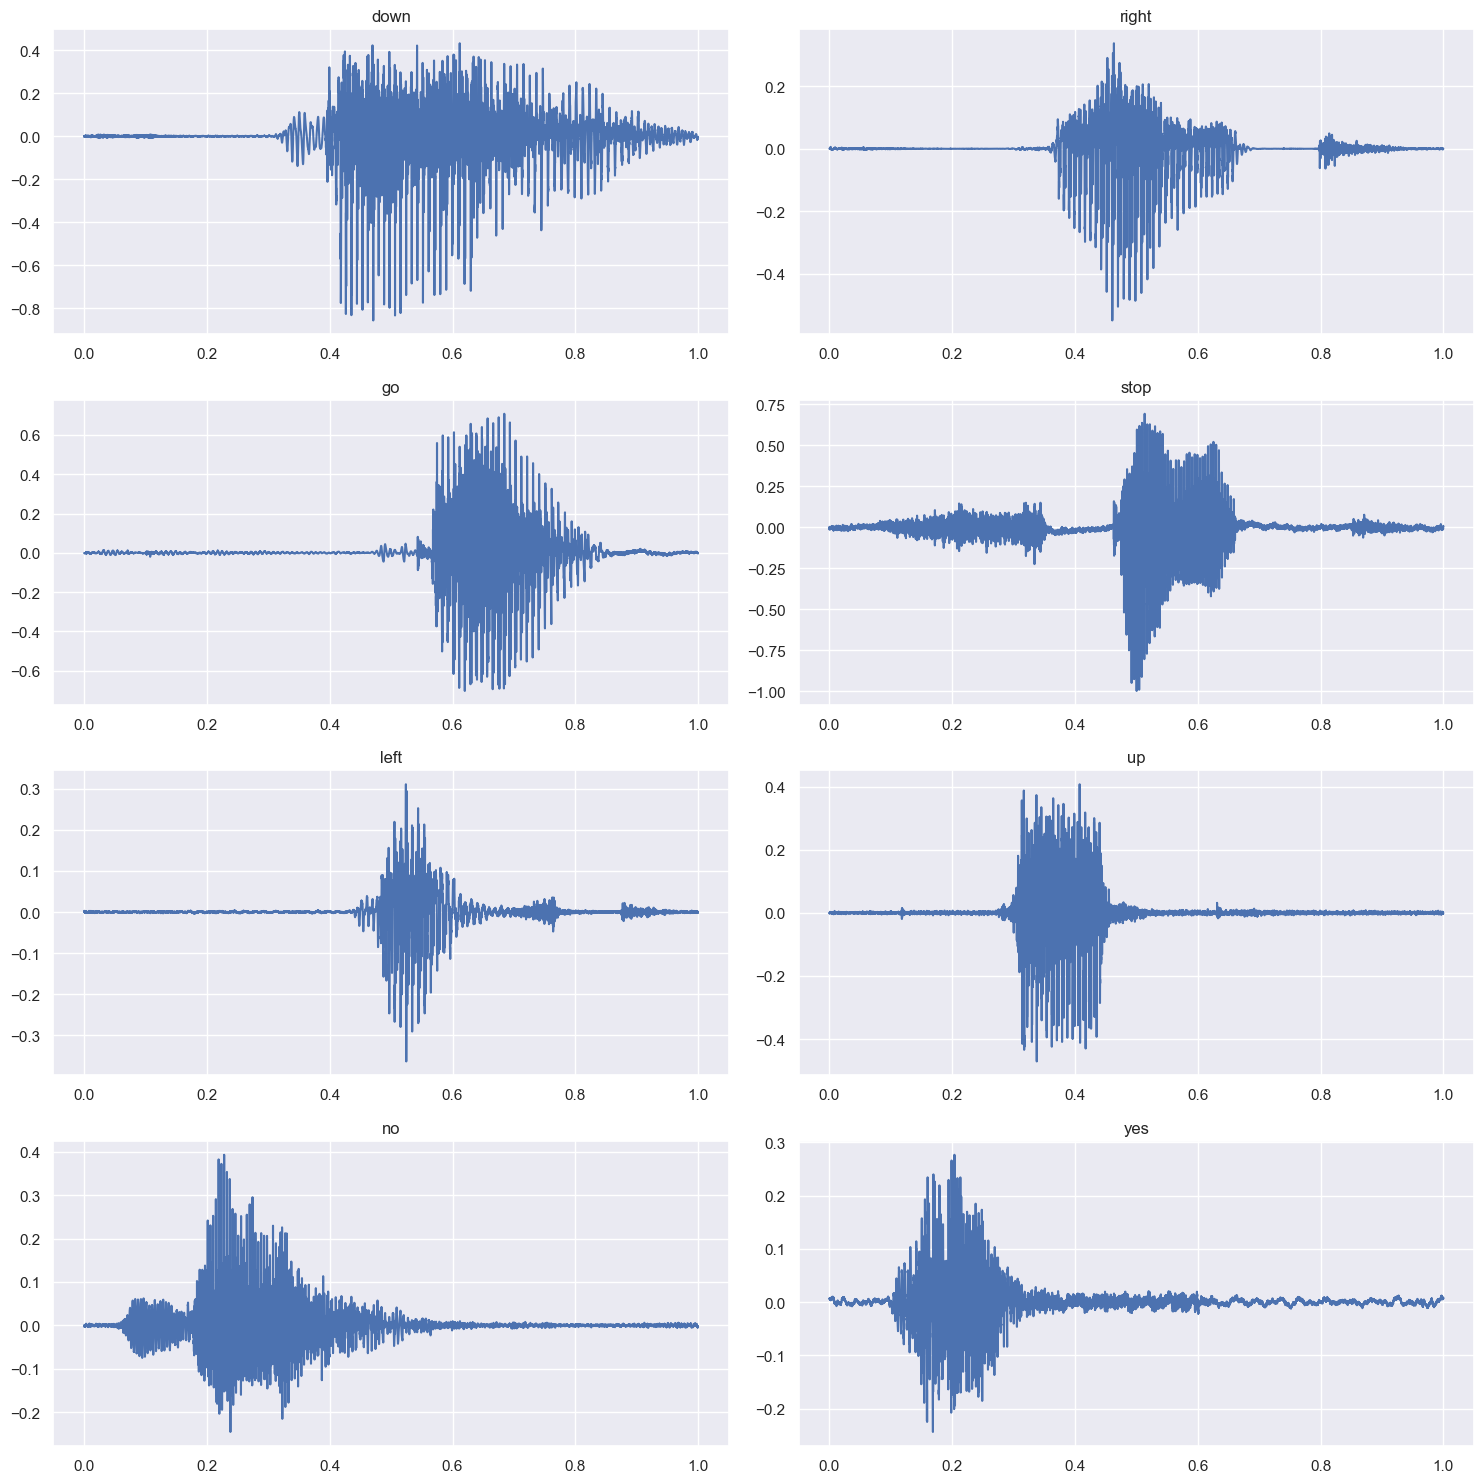

In [15]:
# Exibe a forma de onda de cada audio em um gride, para acentuar as diferenças
plot_grid_audio_waves(dataFrame)

> #### **Espectrogramas de STFT**:
  * Espectrogramas são representações visuais de sinais de áudio em relação ao
    tempo e à frequência, mostrando a intensidade das frequências ao longo do tempo. Os espectrogramas STFT (Transformada de Fourier de Tempo Curto) são uma técnica para calcular espectrogramas dividindo o sinal em pequenos segmentos e aplicando a Transformada de Fourier a cada segmento para analisar suas frequências ao longo do tempo.

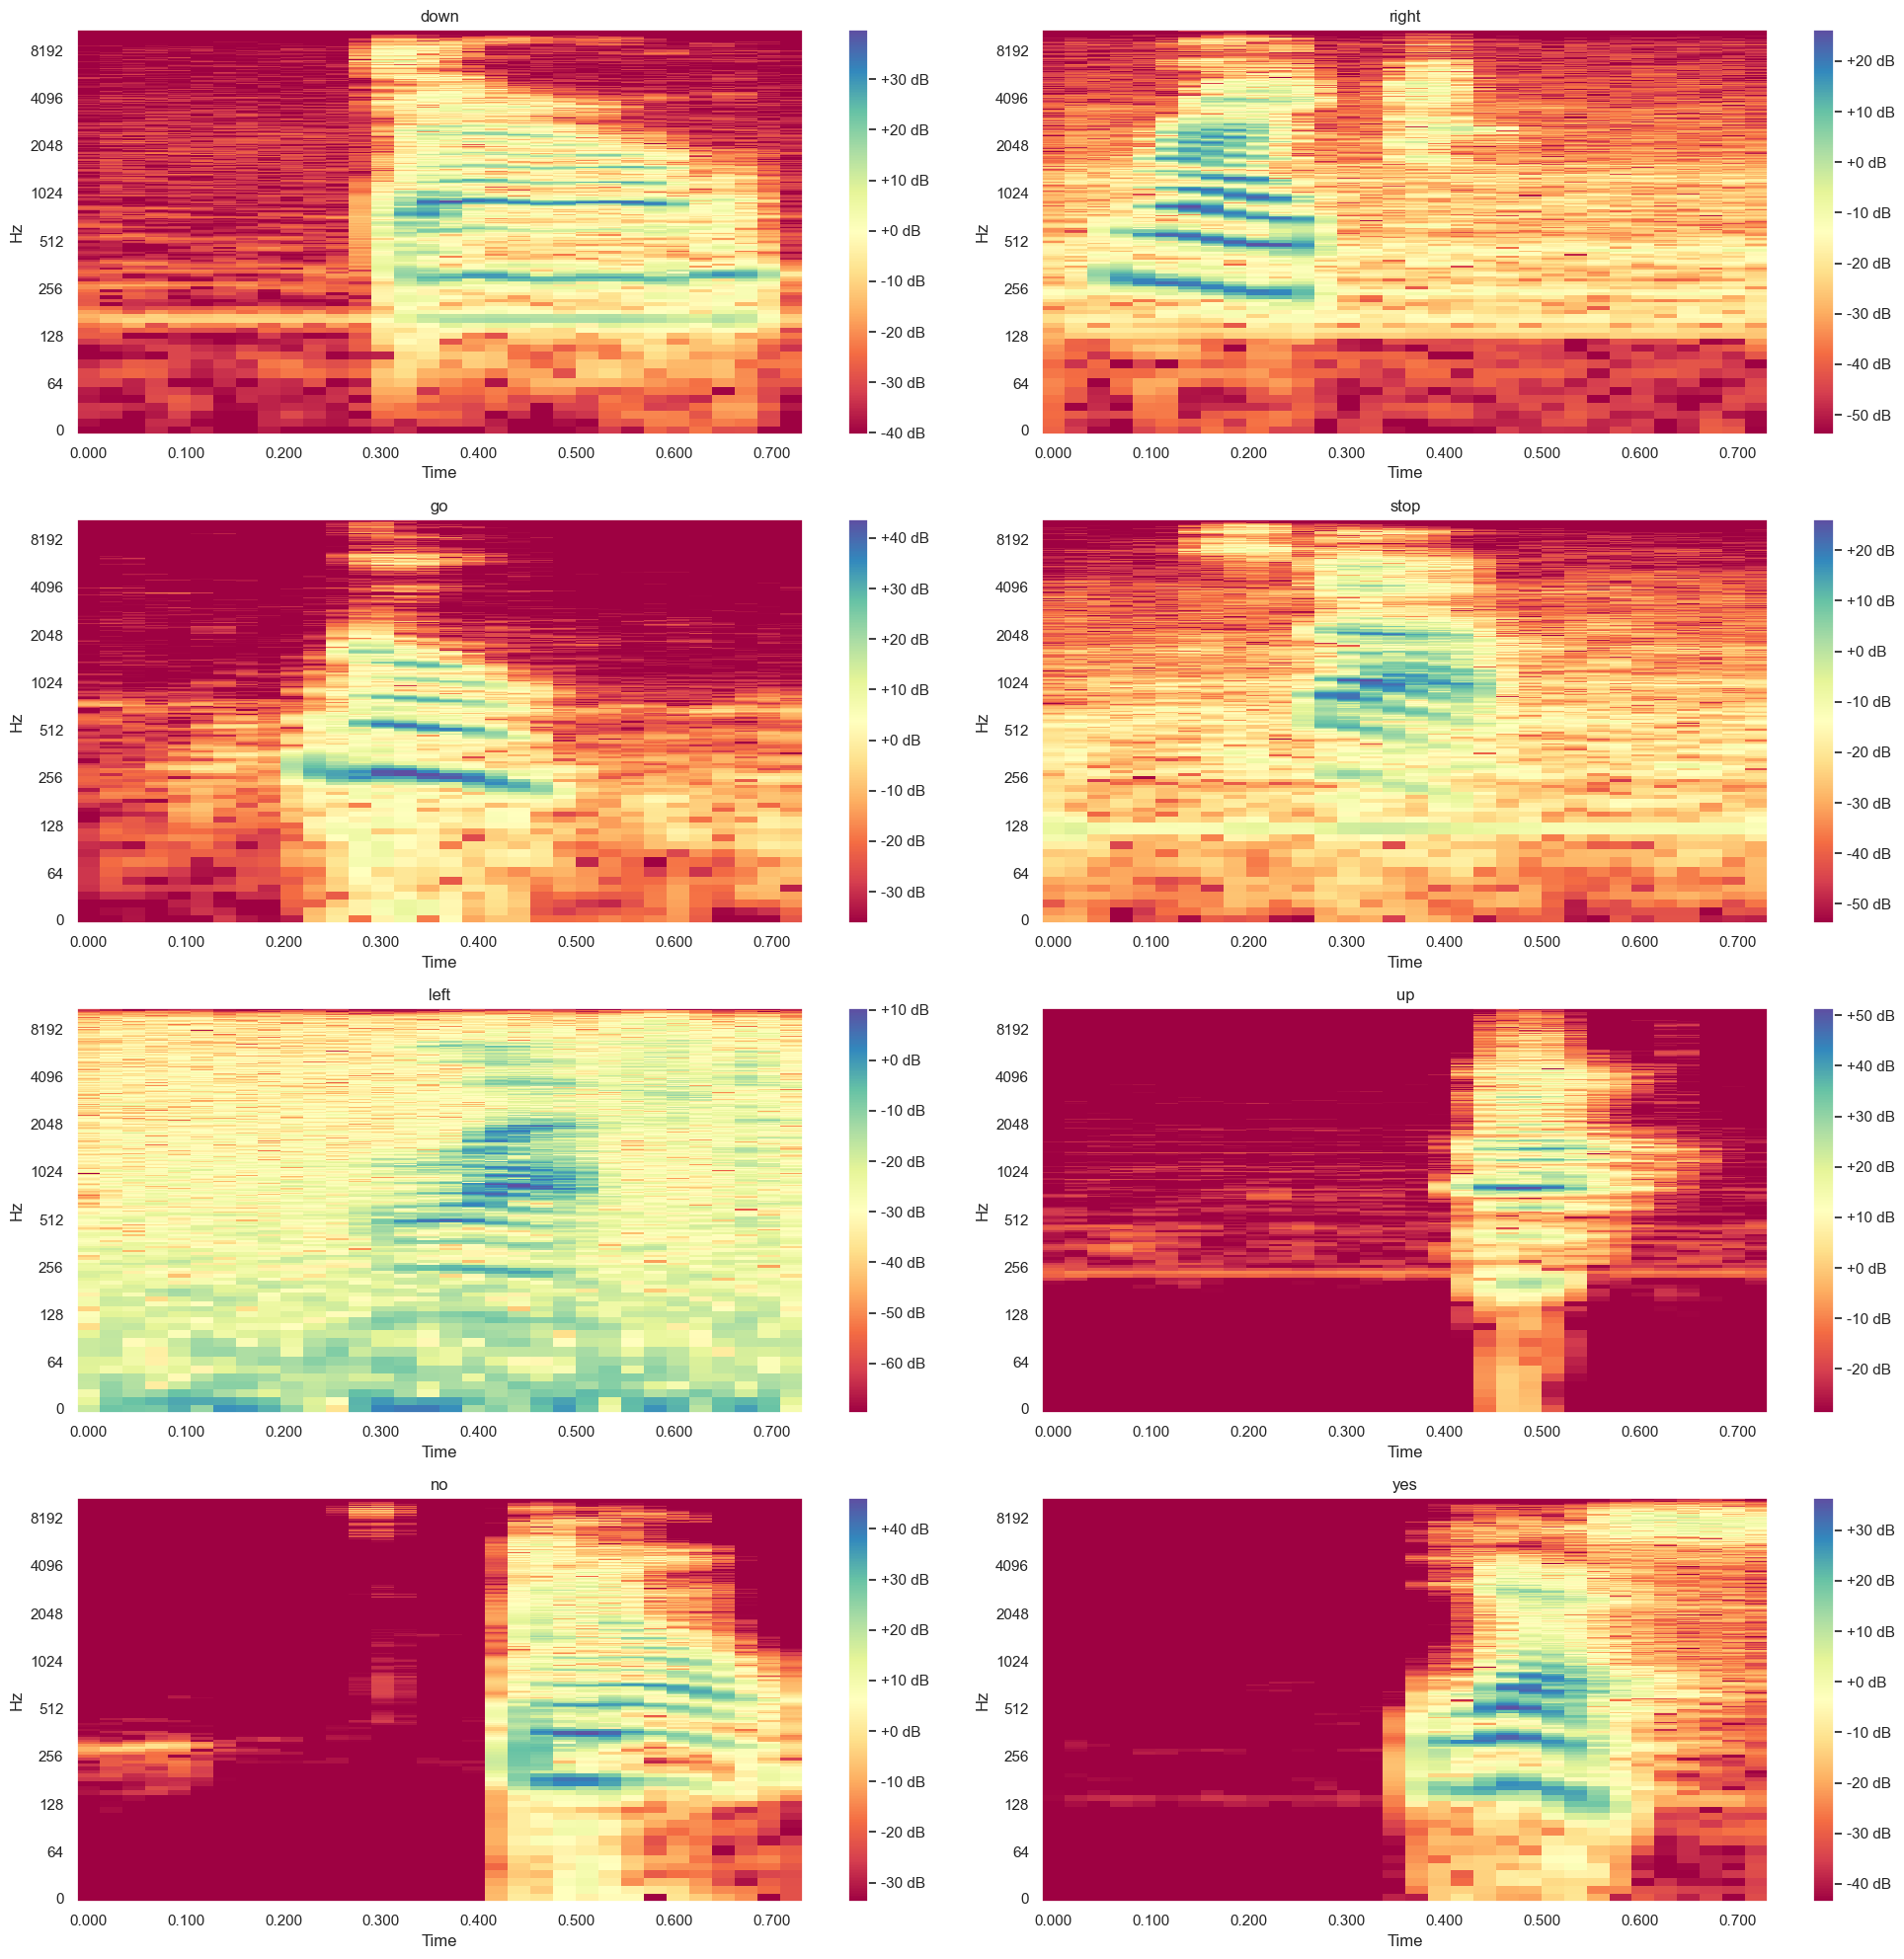

In [16]:
# Plota o padrão de distribuiçao de frequência por audio
plot_fft_audio_frequency2D(dataFrame)


In [17]:
# só execute caso queira ver uma represetaçao em 3D do tempo, frenquencia e amplitude
# plot_audio_frequency3D(dataFrame)

> #### **Espectrogramas de MFCC**:
  * Os espectrogramas MFCC são uma variação que utiliza a escala Mel (https://  
   en.wikipedia.org/wiki/Mel_scale) para   
   representar as frequências. Isso significa que eles são ajustados para refletir melhor a percepção auditiva humana, onde certas frequências são mais distintas do que outras. Os espectrogramas MFCC são úteis para tarefas de reconhecimento de fala e processamento de áudio porque destacam as características mais relevantes do som para o ouvido humano ( sua implementação contém a FFT e a tranfromada do cosseno).

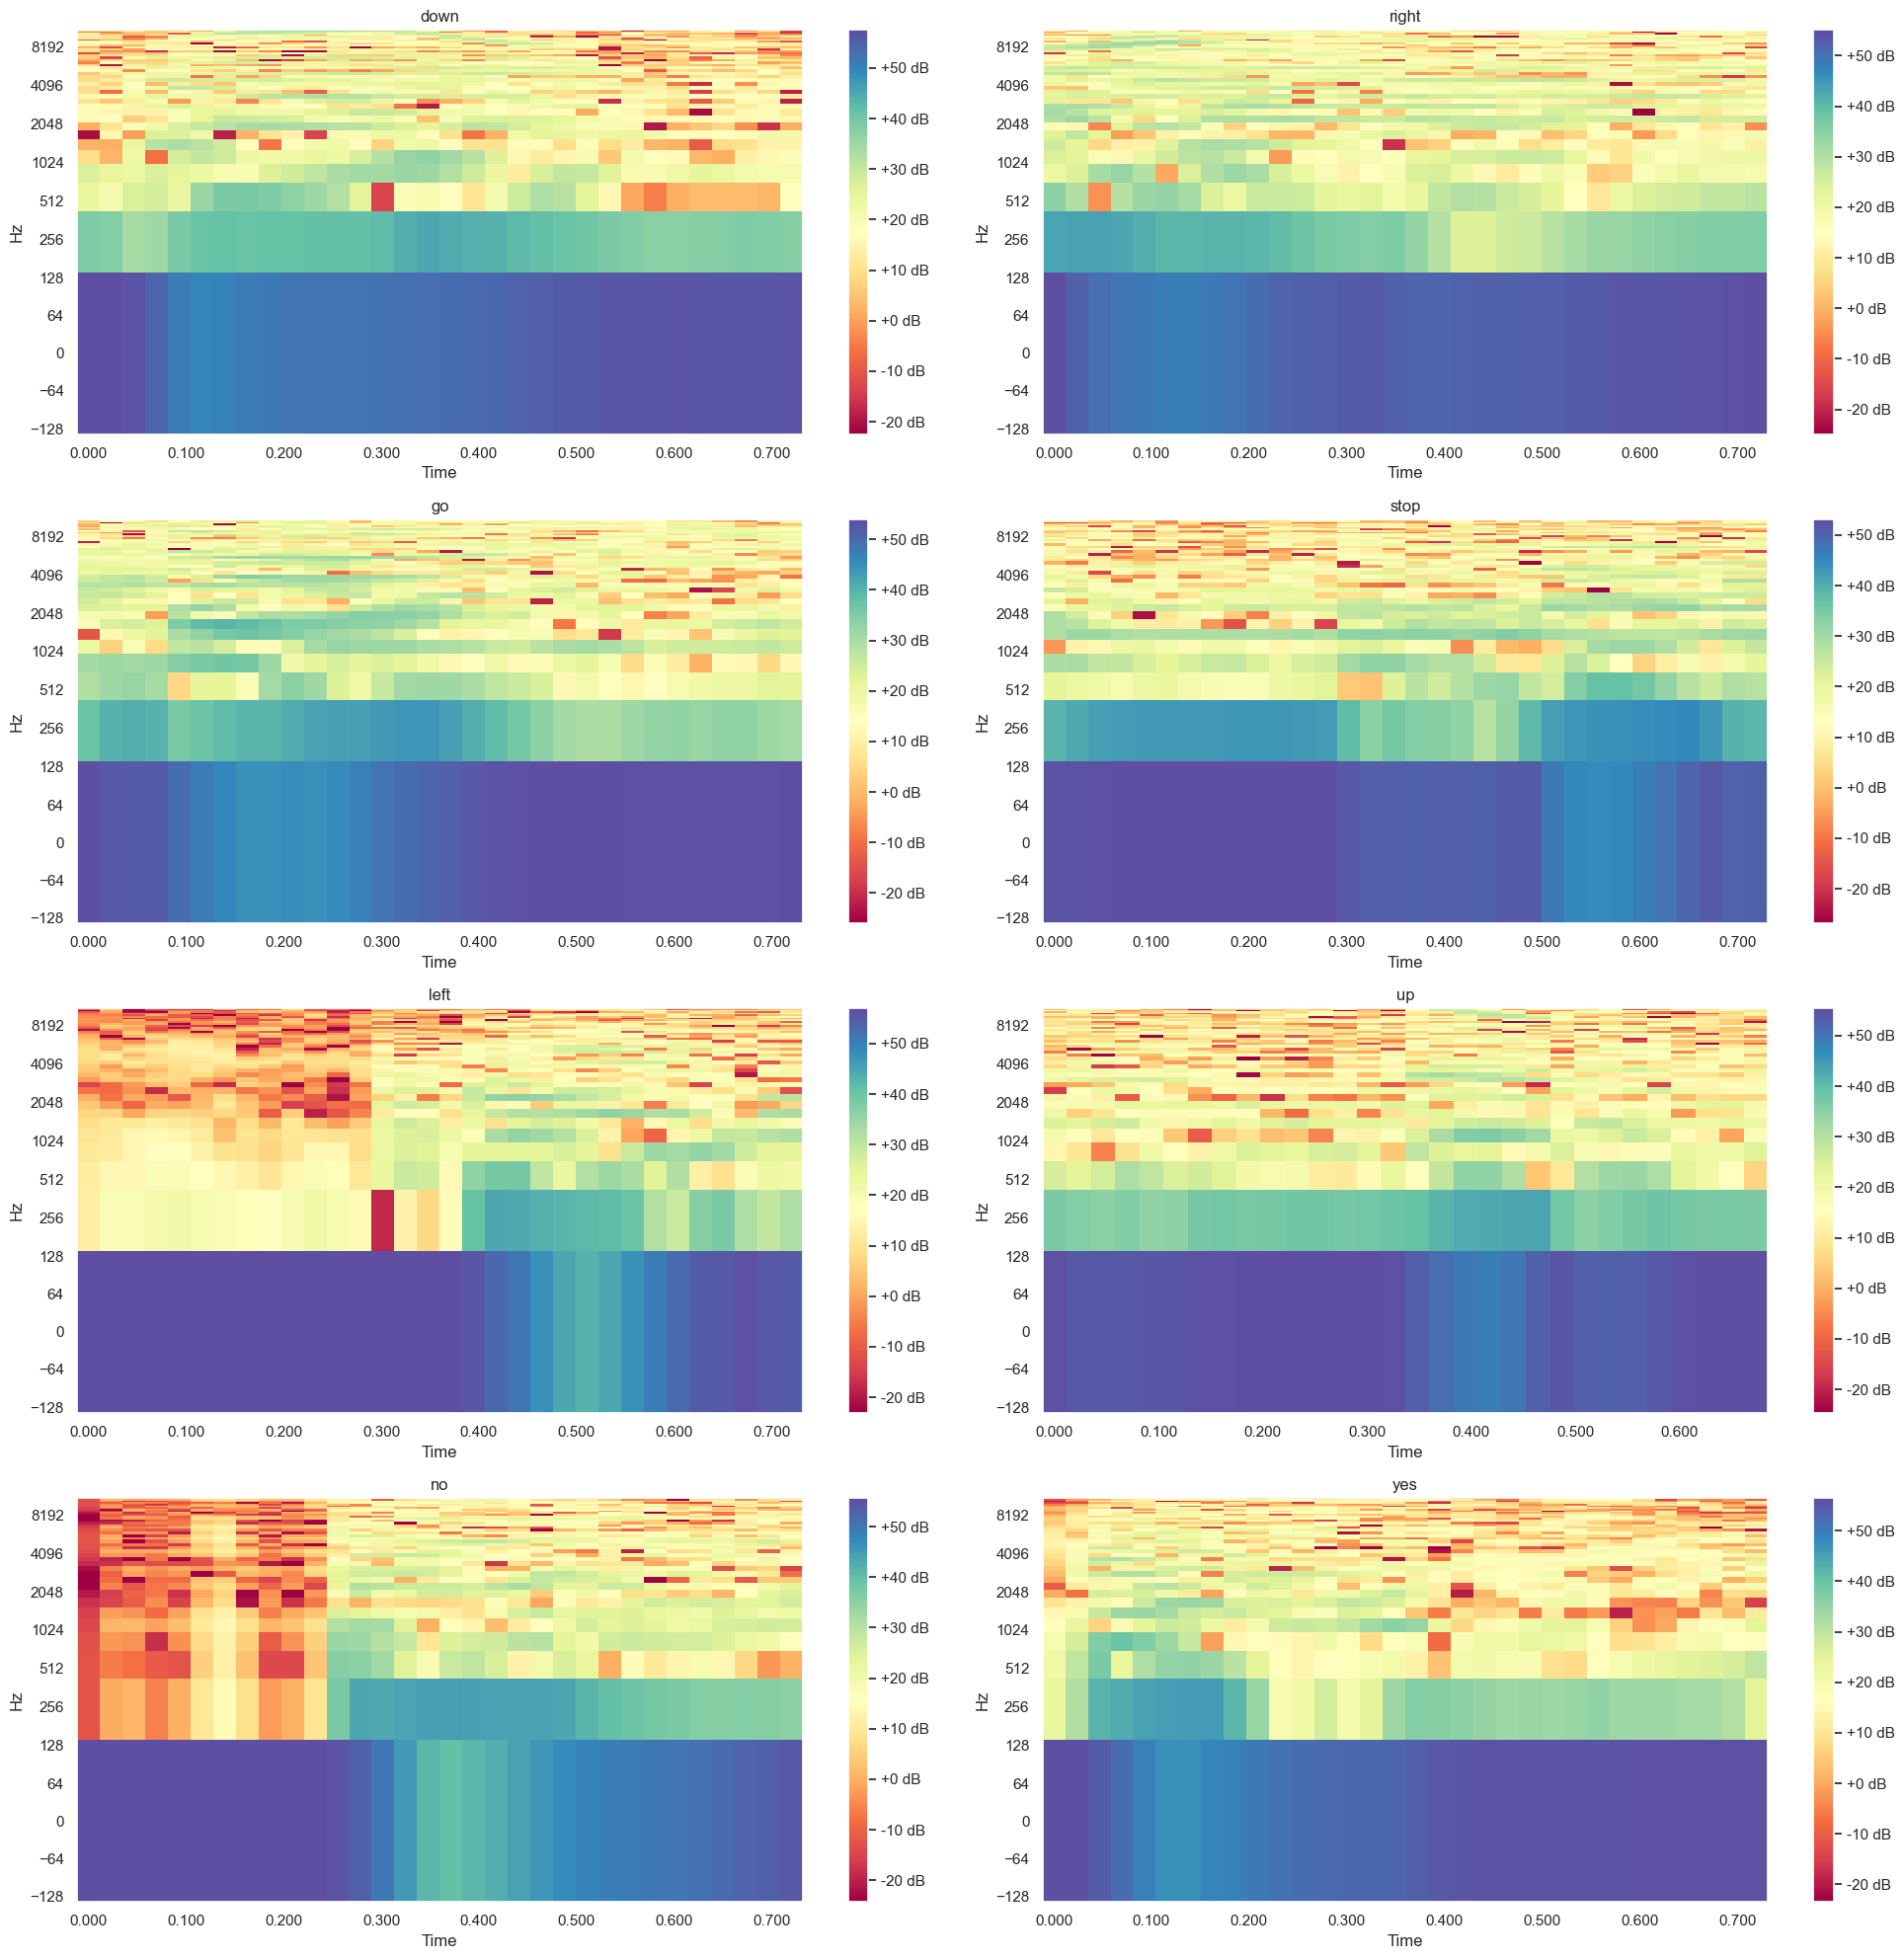

In [18]:
# Plota o padrão de distribuiçao de frequência por audio com mfcc
plot_mfcc_spectogram(dataFrame)


## **Pré-processamento**

> MFCC (Mel Frequency Cepstral Coefficients) é uma técnica amplamente utilizada para extrair características da fala e processar sinais de áudio. Segue uma breve explicação:

 * No pré-processamente, o primeiro passo em qualquer técnica de extração de características da fala é identificar os componentes relevantes do sinal de áudio. Isso envolve separar o conteúdo linguístico das partes indesejadas, como ruído de fundo.
 * No caso do MFCC, aplicamos uma janela deslizante ao sinal de áudio para segmentá-lo em pequenos trechos (chamados de “tramas”).

>**Cálculo dos Coeficientes MFCC:**
 * Para cada trama, calculamos os coeficientes MFCC.
 * Os passos principais são:
 * **Aplicação da Transformada de Fourier:** Transformamos o sinal da trama do
  domínio do tempo para o domínio da frequência.

  > **Mapeamento para Escala Mel:**
    * A escala Mel é uma escala perceptual que se aproxima da maneira como os humanos percebem as diferenças de frequência. Mapeamos as frequências para a escala Mel.

  > **Cálculo dos Coeficientes Cepstrais:**
    * Aplicamos a transformada cepstral inversa para obter os coeficientes MFCC.

  > **Utilização dos Coeficientes MFCC:**
    * Os coeficientes MFCC capturam informações importantes sobre a forma do
      espectro de frequência do sinal de áudio.
      Eles são usados em sistemas de reconhecimento de fala, classificação de idiomas, identificação de oradores e até mesmo para detectar emoções.

In [19]:
#### Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset
speech_data_mfcc = feature_extraction(loaded_speech_data)

100%|██████████| 8000/8000 [00:32<00:00, 244.56it/s]


### **Definindo a proporção da base de dados em treinamento, validação e teste**

* 70% (0.7) para treinar;
* Para a validação usamos 15% (0.15);
* E para teste o restante da base de dados 15% (0.15).



In [20]:
training_dataset, validation_dataset, testing_dataset = create_data_tensor_slice(speech_data_mfcc, speech_data_labels,speech_data_int, proportion=(70, 15, 15))

100%|██████████| 8000/8000 [00:00<00:00, 9665.51it/s] 


## **Criando o modelo**

In [21]:
#Quantidade de Neuronios da camada de saída
output_layer_neurons = len(commands)

In [22]:
model = create_model(output_layer_neurons)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

### **Treinando o modelo**

In [23]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [24]:
import codecs

EPOCHS = 15
BATCH_SIZE = 64

checkpoint_path = r'saved_models/voice_command_recognition.keras'

checkpointer = (tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                  tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                    save_best_only=True))

start = datetime.now()
model_history = model.fit(training_dataset, validation_data=validation_dataset, batch_size=BATCH_SIZE,
                          epochs=EPOCHS, callbacks=[checkpointer],
)
duration = datetime.now() - start
print("Treinamento concluído em: ", duration)

Epoch 1/15


560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3481 - loss: 2.9577 - val_accuracy: 0.6875 - val_loss: 0.9305
Epoch 2/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6608 - loss: 0.9537 - val_accuracy: 0.7067 - val_loss: 0.8045
Epoch 3/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7569 - loss: 0.6538 - val_accuracy: 0.7650 - val_loss: 0.6766
Epoch 4/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8358 - loss: 0.4561 - val_accuracy: 0.7800 - val_loss: 0.7179
Epoch 5/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8640 - loss: 0.3940 - val_accuracy: 0.7925 - val_loss: 0.6680
Epoch 6/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9015 - loss: 0.2860 - val_accuracy: 0.7933 - val_loss: 0.7373
Epoch 7/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9101 - loss: 0.2576 - val_accuracy: 0.7733 - val_loss: 0.8841
Epoch 7: early stopping
Treinamento concluído em:  0:01:10.476647


## **Avaliando o modelo**

In [25]:
y_true, y_pred = test_export_model_files(testing_dataset)

100%|██████████| 1200/1200 [00:00<00:00, 4320.02it/s]





38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


****************************************************************************************************
Taxa de acerto: 78.83333333333333%
****************************************************************************************************


### **Métricas de precisão e perda do modelo:**
  > As métricas de precisão e perda é crucial para avaliar o desempenho de
  um modelo de aprendizado:

  * Precisão: Indica a porcentagem de previsões corretas do total de previsões
  feitas. Uma alta precisão significa que o modelo é eficaz em identificar a classe correta.

  * Perda: Reflete o quão bem o modelo está otimizado durante o treinamento. Uma baixa perda indica que o modelo está fazendo previsões próximas aos valores reais.

  Juntas, essas métricas ajudam a entender não só a eficácia do modelo em termos de resultados corretos, mas também quão confiáveis são essas previsões, permitindo ajustes para melhorar a qualidade do modelo.

In [26]:
plot_loss_and_accuracy(model_history)

### **Matriz de confusão:**
---

> A matriz de confusão é uma ferramenta importante para avaliação de desempenho de modelos de classificação pois:

* Visão Completa: Oferece uma visão detalhada do desempenho do modelo,  
  mostrando não apenas os acertos, mas também os tipos de erros cometidos.
* Diagnóstico: Ajuda a identificar se o modelo está confundindo duas classes, o
  que é crucial para melhorar a precisão.
* Balanceamento: Permite verificar se o modelo está bem balanceado entre as classes ou se está tendencioso para uma classe específica.

In [27]:
plot_confusion_matrix(y_true, y_pred, commands_dict)

### **Executar inferência em um arquivo de áudio:**

In [28]:
import os
import inference as inf
# Diretório que você deseja listar
path = r"mini_speech_commands"

inf.make_inference(model, path, predict, commands)






----------------------------------------------------------------------------------------------------
| Arquivo:  2411
----------------------------------------------------------------------------------------------------
| Path:  mini_speech_commands\left\735845ab_nohash_0.wav
| Command:  left
----------------------------------------------------------------------------------------------------



13
command inválido. Encerrando a reprodução.
0


In [30]:
# # Executar em caso de emergencia 

# file_path = 'Foo-Fighters'
# serialPort='COM9'

# import music as mc

# play='stop'
# current_index = 0

# # print(current_index)
# mc.play_music(play)
# print(current_index)
# # play_music(predict_command, serialPort)

0
0
